# Revelando os dados wiki4HE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pandas_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'


# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

## Verificando Dataset

Este dataset contém dados sobre professores de algumas universidades sobre o uso do Wikipédia como recurso de ensino. Os dados fornecidos contém dados demográficos sobre os professores que participaram do questionário e diversas perguntas que foram respondidas na escala Likert, onde 1 representa "discordo totalmente / nunca" e 5 representa "concordo totalmente / sempre".

In [2]:
df = pd.read_csv('wiki4HE.csv', sep=';')
df.head()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
0,40,0,2,1,14,1,2,?,?,0,...,3,5,5,5,5,4,4,4,1,2
1,42,0,5,1,18,1,2,?,?,0,...,2,4,4,3,4,2,2,4,2,4
2,37,0,4,1,13,1,3,?,?,0,...,1,5,3,5,5,2,2,2,1,3
3,40,0,4,0,13,1,3,?,?,0,...,3,3,4,4,3,4,4,3,3,4
4,51,0,6,0,8,1,3,?,?,1,...,5,5,5,4,4,5,5,5,4,4


Para melhor analisar os dados, é interessante dividir em dois datasets, um para os dados demográficos e outro para as perguntas.

In [3]:
perguntas = df.iloc[:, 10:]
professores = df.iloc[:, :10]

In [4]:
professores

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI
0,40,0,2,1,14,1,2,?,?,0
1,42,0,5,1,18,1,2,?,?,0
2,37,0,4,1,13,1,3,?,?,0
3,40,0,4,0,13,1,3,?,?,0
4,51,0,6,0,8,1,3,?,?,1
...,...,...,...,...,...,...,...,...,...,...
908,43,0,5,1,21,2,?,?,2,0
909,53,0,6,0,25,2,?,?,6,0
910,39,0,5,1,9,2,?,?,4,0
911,40,0,3,1,10,2,?,?,2,0


Vamos alterar os valores "?" por NaN (Not a Number) que é um formato padrão para dados faltantes ou nulos. A partir desta transformação é possível identificar o volume de dados nulos presentes no dataset. Depois isso será feito com os dados completos também.

In [5]:
professores.replace('?', np.nan, inplace=True)
perguntas.replace('?', np.nan, inplace=True)

In [6]:
professores.isna().sum()

AGE                 0
GENDER              0
DOMAIN              2
PhD                 0
YEARSEXP           23
UNIVERSITY          0
UOC_POSITION      113
OTHER_POSITION    261
OTHERSTATUS       540
USERWIKI            4
dtype: int64

Como podemos notar, diversas colunas apresentam valores faltantes. Sendo que, as colunas "UOC_POSITION", "OTHER_POSITION" e "OTHERSTATUS" possuem o maior número de casos de valores faltantes. O que é compreensivel, uma vez que nem sempre estes campos são de preenchimento obrigatório e os mesmos não passam tanta informação quanto os demais dados demográficos. Assim iremos remover estas colunas da nossa análise.

In [7]:
professores.drop(columns=['UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS'], inplace=True)

In [8]:
professores.isna().sum()

AGE            0
GENDER         0
DOMAIN         2
PhD            0
YEARSEXP      23
UNIVERSITY     0
USERWIKI       4
dtype: int64

Como sobraram poucas linhas de dados com valor nulo, é interressante remover estas linhas para processeguir com a análise.

In [9]:
professores.dropna(inplace=True)
professores.reset_index(drop=True)

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,USERWIKI
0,40,0,2,1,14,1,0
1,42,0,5,1,18,1,0
2,37,0,4,1,13,1,0
3,40,0,4,0,13,1,0
4,51,0,6,0,8,1,1
...,...,...,...,...,...,...,...
880,43,0,5,1,21,2,0
881,53,0,6,0,25,2,0
882,39,0,5,1,9,2,0
883,40,0,3,1,10,2,0


In [10]:
professores.isna().sum()

AGE           0
GENDER        0
DOMAIN        0
PhD           0
YEARSEXP      0
UNIVERSITY    0
USERWIKI      0
dtype: int64

Vamos colocar na mesma escala a idade e os anos de experiência utilizando o MinMaxScaler que normaliza os dados contínuos em um valor entre 0 e 1. Antes disso, será necessário alterar a coluna YEAREXP para uma coluna contínua e não mais categorica.

In [11]:
professores.YEARSEXP = professores.YEARSEXP.astype(int)

In [12]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['YEARSEXP', 'AGE']

professores_transform = pd.DataFrame(data = professores)
professores_transform[numerical] = scaler.fit_transform(professores[numerical])

professores_transform = pd.DataFrame(data = professores_transform, columns=professores.columns)
# Show an example of a record with scaling applied
display(professores_transform.head())

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,USERWIKI
0,0.369565,0,2,1,0.325581,1,0
1,0.413043,0,5,1,0.418605,1,0
2,0.304348,0,4,1,0.302326,1,0
3,0.369565,0,4,0,0.302326,1,0
4,0.608696,0,6,0,0.186047,1,1


Vamos descobrir a proporção entre homens e mulheres, em relação aos professores entrevistados.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


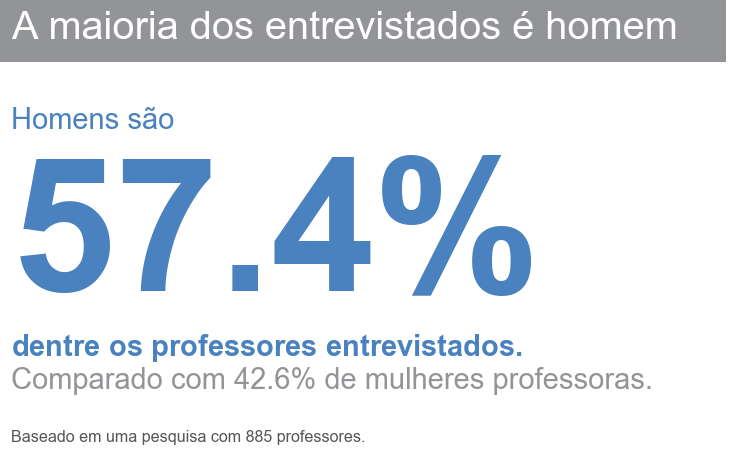

In [13]:
# finding out the male/female proportion
male_prof = round((len(professores[professores.GENDER == 0])/len(professores))*100,2)

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# change the appearance of ticks, tick labels, and gridlines 
plt.tick_params(bottom='off', left='off', labelleft='off', labelbottom='off')

# titile the plot
plt.text(-0.15, 1.03,
         'A maioria dos entrevistados é homem '+' '*2,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7, 'pad': 10, 'edgecolor': 'none'})

# footnote with the data source
plt.text(-0.15, 0.04,
         'Baseado em uma pesquisa com 885 professores.',
         fontsize=10.5,
         color=GRAY3)

# add note to the plot
plt.text(-0.15, 0.81,
         'Homens são ',
         fontsize=19,
         color=BLUE2)

# add note to the plot
plt.text(-0.15, 0.41,
         '$\\bf{'+str(male_prof)+'\%}$', # use mathtext \\bf for bold text
         fontsize=122,
         color=BLUE2)

# add note to the plot
plt.text(-0.15, 0.25,
         # use mathtext \\bf for bold text
         '$\\bf{dentre\ os\ professores\ entrevistados.}$',
         fontsize=19,
         color=BLUE2)

# add note to the plot
plt.text(-0.15, 0.17,
         'Comparado com '+str(100-male_prof)+'% de mulheres professoras.',
         fontsize=19,
         color=GRAY7)

plt.axis('off');

Agora vamos visualizar os bloxplots referêntes as váriáveis contínuas, ou seja, a idade e os anos de experiência já normalizados para a mesma escala entre 0 e 1.

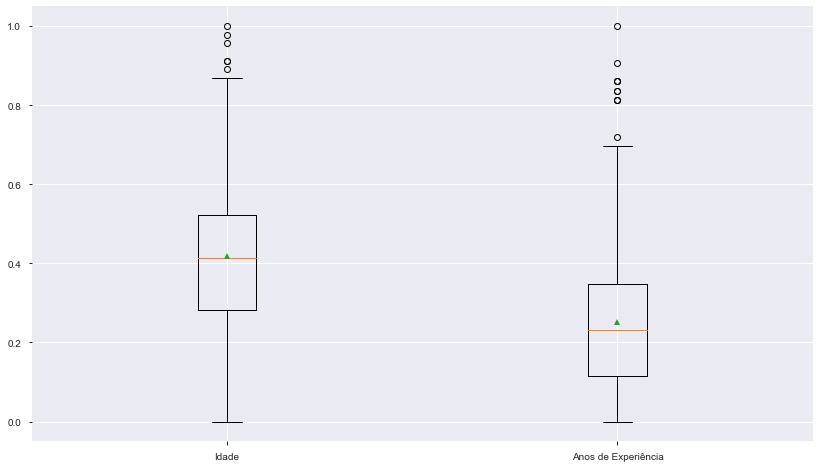

In [14]:
plt.subplots(figsize=(14,8))
plt.boxplot([professores_transform.AGE, professores_transform.YEARSEXP], 
            labels=['Idade', 'Anos de Experiência'], showmeans=True);

Como podemos notar, a média e a mediana das idades ficou próxima de 0.4 enquanto a média e mediana dos anos de experiência ficou abaixo dos 0.3. A baixo vamos verificar a distribuição das demais características dos professores entrevistados.

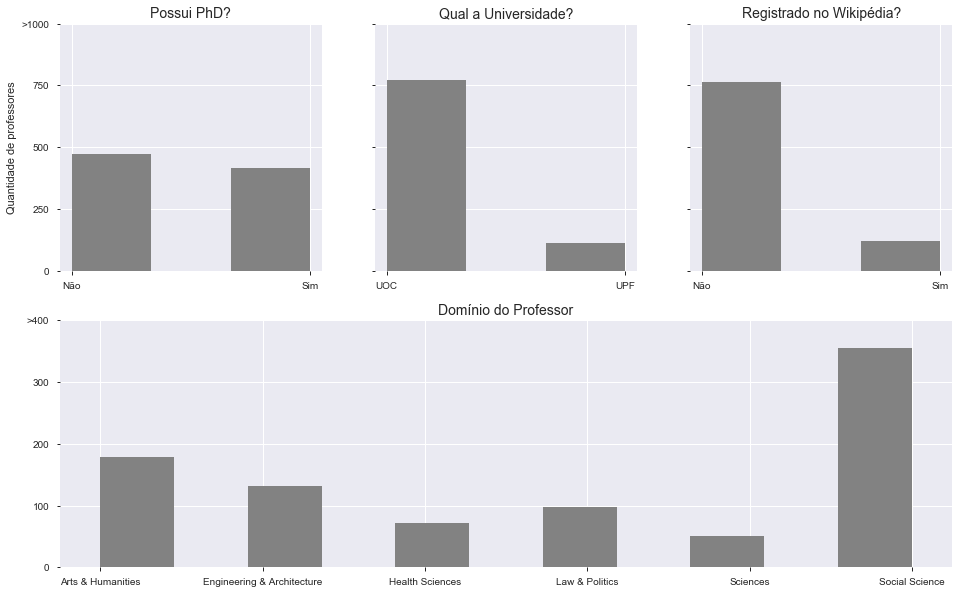

In [15]:
fig = plt.figure(figsize = (16,10));
        
ax = fig.add_subplot(2, 3, 1)
counts, bins, patches = ax.hist(professores['PhD'].map({0: 'Não', 1: 'Sim'}).sort_values(), bins = 3, color =GRAY6)
ax.set_title("Possui PhD?", fontsize = 14)
ax.set_ylabel("Quantidade de professores")
ax.set_ylim((0, 1000))
ax.set_yticks([0, 250, 500, 750, 1000])
ax.set_yticklabels([0, 250, 500, 750, ">1000"])

ax = fig.add_subplot(2, 3, 2)
ax.hist(professores['UNIVERSITY'].map({1.0: 'UOC', 2.0: 'UPF'}), bins = 3, color = GRAY6)
ax.set_title("Qual a Universidade?", fontsize = 14)
ax.set_ylim((0, 1000))
ax.set_yticks([0, 250, 500, 750, 1000])
ax.set_yticklabels([ "",  "",  "",  "", ""])

ax = fig.add_subplot(2, 3, 3)
ax.hist(professores['USERWIKI'].map({"0": 'Não', "1": 'Sim'}).sort_values(), bins = 3, color = GRAY6)
ax.set_title("Registrado no Wikipédia?", fontsize = 14)
ax.set_ylim((0, 1000))
ax.set_yticks([0, 250, 500, 750, 1000])
ax.set_yticklabels([ "",  "",  "",  "", ""]);

ax = fig.add_subplot(2, 1, 2)
ax.hist(professores['DOMAIN'].map({'1': "Arts & Humanities", '2':"Sciences", '3':"Health Sciences",
                                   '4':"Engineering & Architecture", '5':"Law & Politics", 
                                   '6':"Social Science"}).sort_values(), bins = 11, color = GRAY6)
ax.set_title("Domínio do Professor", fontsize = 14)
ax.set_ylim((0, 400))
ax.set_yticks([0, 100, 200, 300, 400])
ax.set_yticklabels([0, 100, 200, 300, ">400"]);

Como podemos notar nos gráficos acima, a maioria dos professores entrevistados não possuem PhD, são da universidade UOC e não estão registrados no Wikipédia. Sendo que boa parte trabalha em ciências sociais, artes e humanidades.

In [16]:
perguntas.replace('?', np.nan, inplace=True)
print(perguntas.isnull().sum())
perguntas = perguntas.astype(float)
perguntas.fillna(value=6, inplace=True)

PU1       7
PU2      11
PU3       5
PEU1      4
PEU2     14
PEU3     97
ENJ1      7
ENJ2     17
Qu1       7
Qu2      10
Qu3      15
Qu4      22
Qu5      29
Vis1     72
Vis2    117
Vis3      8
Im1      22
Im2      20
Im3      57
SA1      11
SA2      12
SA3      11
Use1     14
Use2     17
Use3      9
Use4     23
Use5     15
Pf1      11
Pf2       6
Pf3      14
JR1      27
JR2      53
BI1      32
BI2      43
Inc1     35
Inc2     35
Inc3     37
Inc4     42
Exp1     13
Exp2     11
Exp3     13
Exp4     14
Exp5     13
dtype: int64


Existem várias formas de tratarmos os dados nulos no dataset das perguntas. Uma das formas seria tratar a escala likert como contínua com valores entre 1 e 5, assim poderiamos colocar a média de cada pergunta nos valores faltantes, como será feito com os dados completos mais a frente. Porém, desta forma não seria possível realizar uma análise de porque os dados estão nulos naquelas perguntas. Portanto, optamos por incluir uma nova categoria nas perguntas (com o número 6), para denotar os campos que eram nulos. 

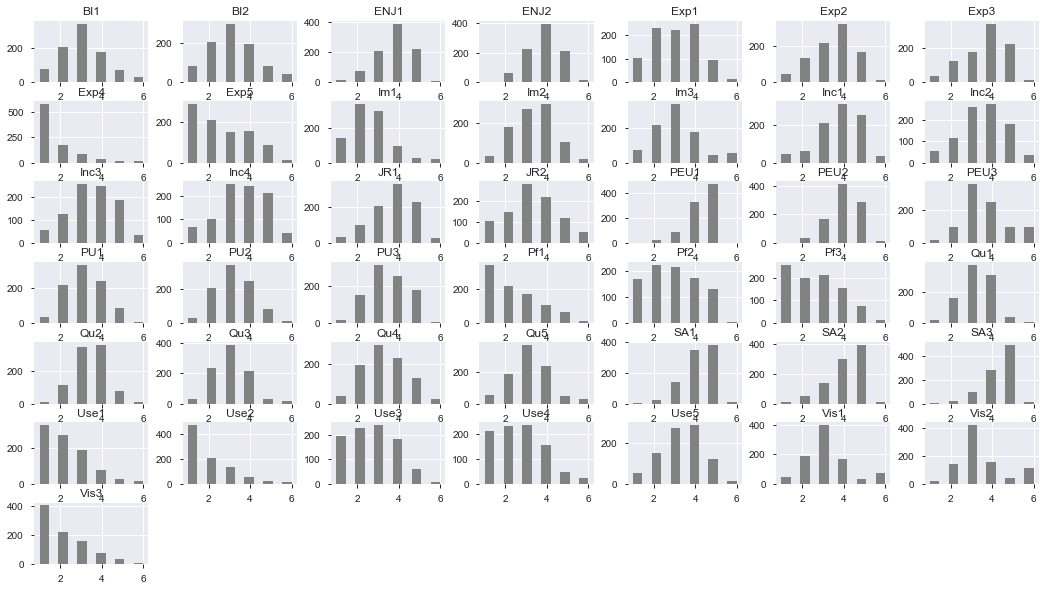

In [17]:
perguntas.hist(figsize=(18,10), color=GRAY6, bins=11);

Como podemos ver a maioria das perguntas possuem distribuição próxima da normal, com a maioria das respostas concentrada entre 2, 3 e 4 (Concordo, Não concordo nem discordo e Discordo). Porém, existem algumas perguntas que a maioria das respostas se concentrou em discordo fortemente, como: Use1, Use2, Vis3 e Exp5. Estes casos se referêm a utilização do wikipédia para elaboração de material e atividades educacionais, citação de wikipédia em trabalhos acadêmicos, a utilização do wikipédia para trabalhar com os alunos, entre outros. 

Ao observarmos a ultima coluna dos gráficos acima podemos notar a quantidade de dados faltantes para cada pergunta. Nota-se que PEU3, Vis1 e Vis2 possuem maior quantidade de respostas faltando, ao analisarmos estas perguntas, respectivamente, "É fácil adicionar ou editar informações na Wikipedia", "Wikipedia melhora a visibilidade do trabalho dos alunos" e "É fácil ter um registro das contribuições feitas na Wikipedia". É possível perceber que são perguntas para usuário do wikipédia, sendo que a maioria dos professores não está cadastrado na plataforma, como visto anteriormente. Assim, é compreensível que estas questões possuam maior número de perguntas sem resposta.

___

In [18]:
data = df.drop(columns=['UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS'])
data.replace('?', np.nan, inplace=True)
data = data.dropna(subset=['DOMAIN', 'YEARSEXP', 'USERWIKI'])
data.head()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,USERWIKI,PU1,PU2,PU3,...,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
0,40,0,2,1,14,1,0,4,4,3,...,3,5,5,5,5,4,4,4,1,2
1,42,0,5,1,18,1,0,2,3,3,...,2,4,4,3,4,2,2,4,2,4
2,37,0,4,1,13,1,0,2,2,2,...,1,5,3,5,5,2,2,2,1,3
3,40,0,4,0,13,1,0,3,3,4,...,3,3,4,4,3,4,4,3,3,4
4,51,0,6,0,8,1,1,4,3,5,...,5,5,5,4,4,5,5,5,4,4


In [19]:
data.iloc[:, 7:] = data.iloc[:, 7:].astype(float)
data = data.apply(lambda x: x.fillna(round(x.mean(), 0)),axis=0)

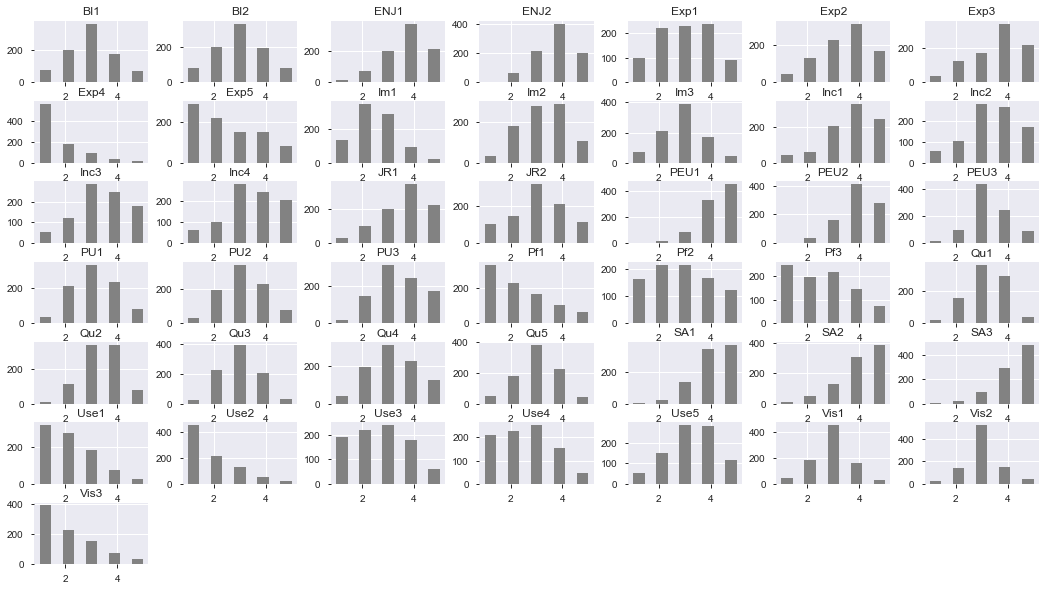

In [20]:
data.iloc[:, 7:].hist(figsize=(18,10), color=GRAY6, bins=9);

## Análise das perguntas referêntes ao "Prazer Percebido" no Wikipédia

Primeiramente vamos verificar a distribuição geral das seguintes perguntas:

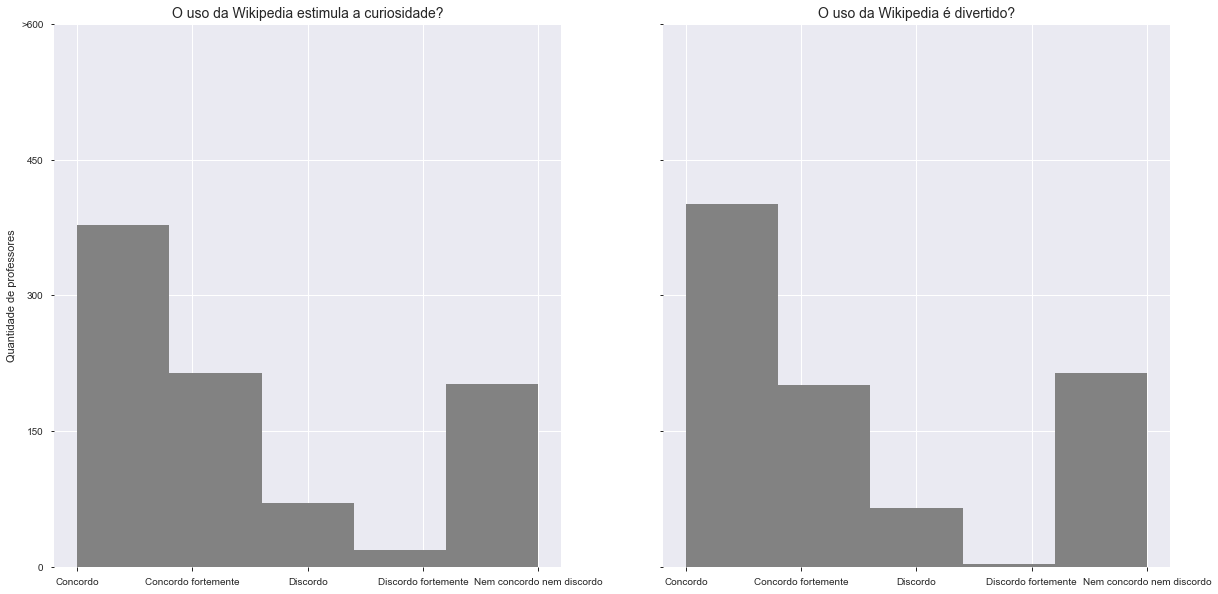

In [21]:
fig = plt.figure(figsize = (20,10));
        
ax = fig.add_subplot(1, 2, 1)
counts, bins, patches = ax.hist(data['ENJ1'].map({1.0: 'Discordo fortemente', 2.0: 'Discordo', 
                                                  3.0: 'Nem concordo nem discordo', 4.0: 'Concordo', 
                                                  5.0: 'Concordo fortemente'}).sort_values(), bins = 5, color =GRAY6)
ax.set_title("O uso da Wikipedia estimula a curiosidade?", fontsize = 14)
ax.set_ylabel("Quantidade de professores")
ax.set_ylim((0, 500))
ax.set_yticks([0, 150, 300, 450, 600])
ax.set_yticklabels([0, 150, 300, 450, ">600"])

ax = fig.add_subplot(1, 2, 2)
ax.hist(data['ENJ2'].map({1.0: 'Discordo fortemente', 2.0: 'Discordo', 
                          3.0: 'Nem concordo nem discordo', 4.0: 'Concordo', 
                          5.0: 'Concordo fortemente'}).sort_values(), bins = 5, color = GRAY6)
ax.set_title("O uso da Wikipedia é divertido?", fontsize = 14)
ax.set_ylim((0, 500))
ax.set_yticks([0, 150, 300, 450, 600])
ax.set_yticklabels([ "",  "",  "",  "", ""]);

Podemos notar aqui que a maioria das respostas foi que concorda, seguido por não concorda e nem discorda e concordo fortemente. Vamos verificar agora se destas respostas a maioria que concorda é mulher ou homem?

In [22]:
genero = data.groupby(['GENDER', 'ENJ1'])['ENJ1'].count()

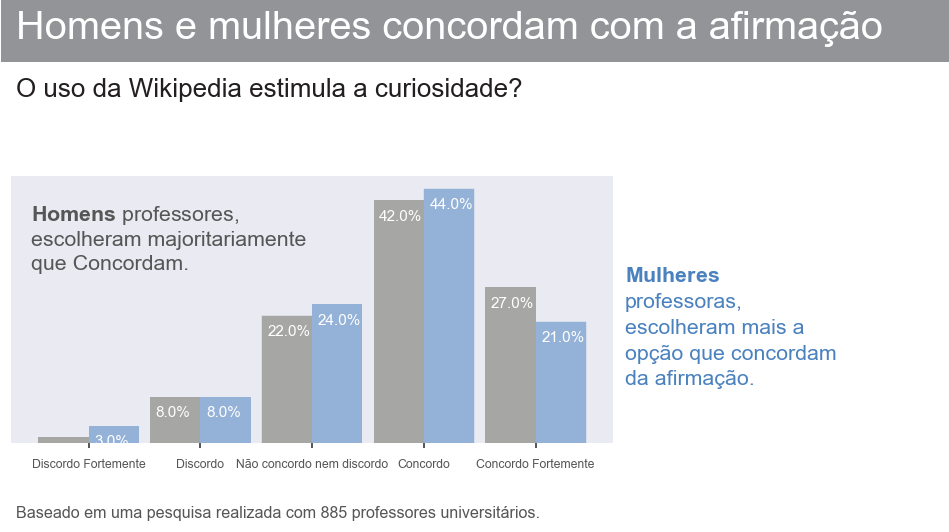

In [23]:
# survey responses
X = ['Discordo Fortemente', 'Discordo', 'Não concordo nem discordo', 'Concordo', 'Concordo Fortemente']
Y = list(round((genero[0]/len(data[data['GENDER'] == 0]))*100, 0))
Z = list(round((genero[1]/len(data[data['GENDER'] == 1]))*100, 0))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'Homens e mulheres concordam com a afirmação' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso da Wikipedia estimula a curiosidade?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -13,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         '$\\bf{Homens}$ professores,\n'  # use mathtext \\bf for bold text
         'escolheram majoritariamente\n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         '$\\bf{Mulheres}$\n'  # use mathtext \\b for bold text
         'professoras,\n'
         'escolheram mais a\n'
         'opção que concordam\n'  # use mathtext \\mathit for italic text
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0)

A partir do gráfico acima podemos notar que proporcionalmente um pouco mais de mulheres não concordam e nem descordam em relação aos homens e 44% das mulheres concordam que o uso do wikipédia estimula a curiosidade.

Vamos verificar agora como foi o comportamento dos professores para esta mesma pergunta (O uso do Wikipédia estimula a curiosidade?) em relação aos que possuem PhD e aos que não possuem.

In [24]:
phd = data.groupby(['PhD', 'ENJ1'])['ENJ1'].count()

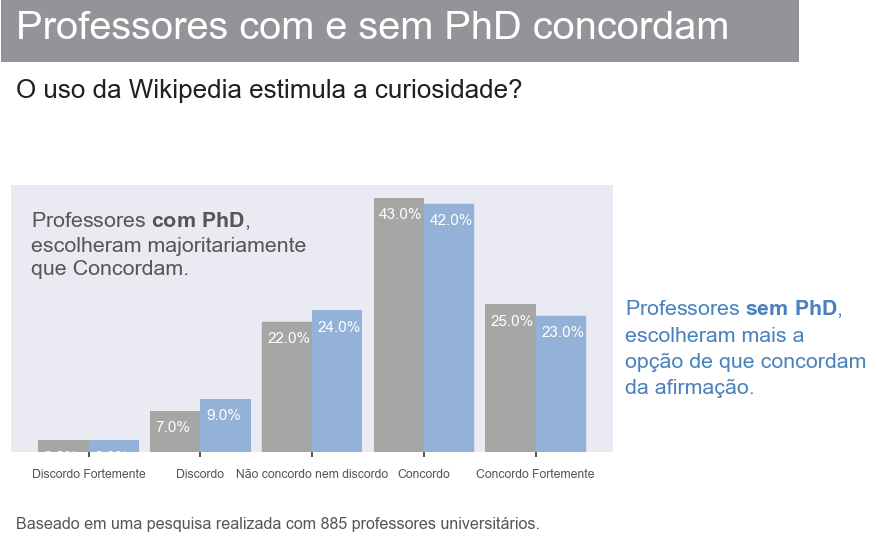

In [25]:
Y = list(round((phd[0]/len(data[data['PhD'] == 0]))*100, 0))
Z = list(round((phd[1]/len(data[data['PhD'] == 1]))*100, 0))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'Professores com e sem PhD concordam' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso da Wikipedia estimula a curiosidade?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -13,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         'Professores $\\bf{com\ PhD}$,\n'  # use mathtext \\bf for bold text
         'escolheram majoritariamente\n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         'Professores $\\bf{sem\ PhD}$,\n'
         'escolheram mais a\n'
         'opção de que concordam\n'  # use mathtext \\mathit for italic text
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0)

No gráfico acima fica evidente que professores sem PhD discordam e "não concordam e nem discordam", proporcionalmente mais do que professores com PhD. Ainda assim, 43% dos professores com PhD concordam e 42% dos professores sem PhD também concordam.

Verificaremos agora a proporção em relação aos professores com registro no wikipédia.

In [26]:
data['USERWIKI'] = data['USERWIKI'].astype(int)
wiki = data.groupby(['USERWIKI', 'ENJ1'])['ENJ1'].count()

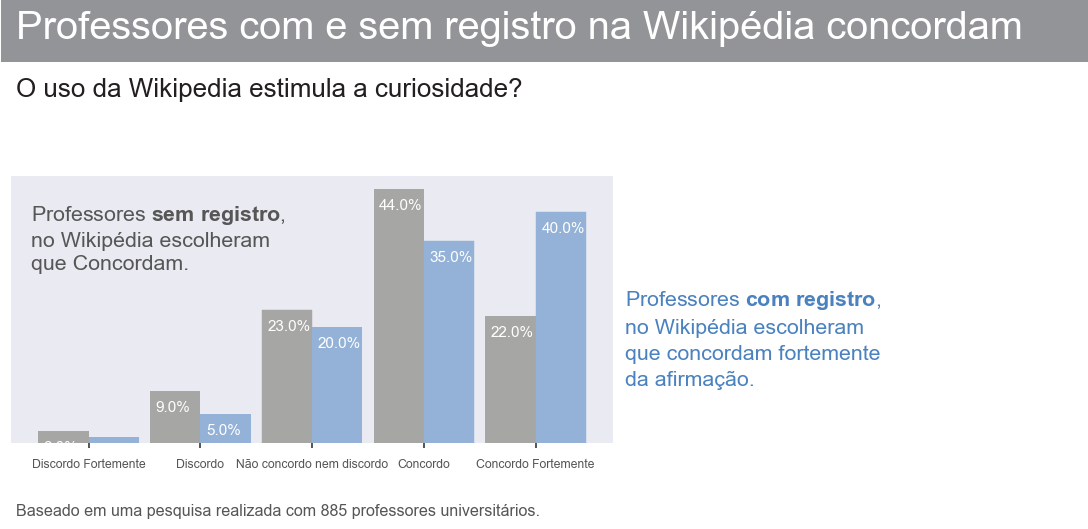

In [27]:
Y = list(round((wiki[0]/len(data[data['USERWIKI'] == 0]))*100, 0))
Z = list(round((wiki[1]/len(data[data['USERWIKI'] == 1]))*100, 0))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'Professores com e sem registro na Wikipédia concordam' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso da Wikipedia estimula a curiosidade?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -12.5,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         'Professores $\\bf{sem\ registro}$,\n'  # use mathtext \\bf for bold text
         'no Wikipédia escolheram \n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         'Professores $\\bf{com\ registro}$,\n'
         'no Wikipédia escolheram \n'
         'que concordam fortemente \n'
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0)

Os professores com registro no Wikipédia concordam fortemente com a afirmação (40% deles), sendo que professores sem registro no wikipédia tendem a responder mais que discordam e "não concordam e nem discordam", assim como que concordam.

Vamos verificar estas três características dos professores, mas agora para a pergunta "O uso do Wikipédia é divertido?".

In [28]:
gender_2 = data.groupby(['GENDER', 'ENJ2'])['ENJ2'].count()

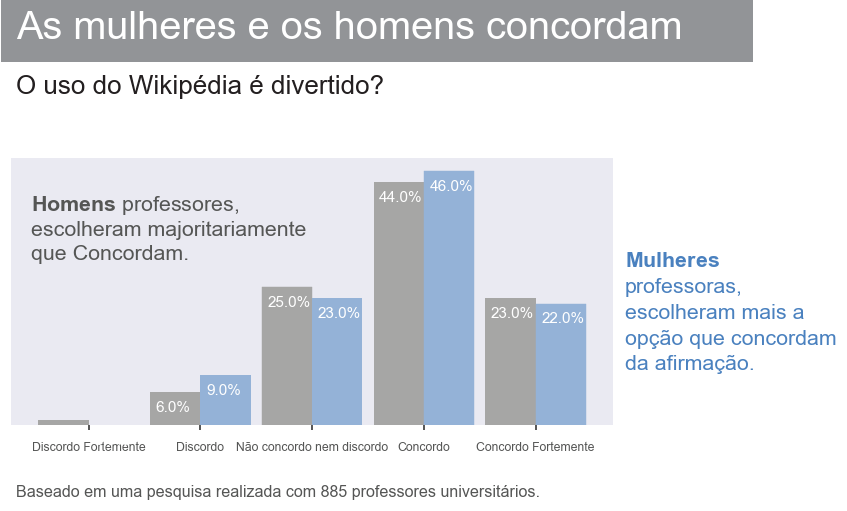

In [29]:
Z = [0.0]
Y = list(round((gender_2[0]/len(data[data['GENDER'] == 0]))*100, 0))
Z.extend(list(round((gender_2[1]/len(data[data['GENDER'] == 1]))*100, 0)))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'As mulheres e os homens concordam' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso do Wikipédia é divertido?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -13,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         '$\\bf{Homens}$ professores,\n'  # use mathtext \\bf for bold text
         'escolheram majoritariamente\n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         '$\\bf{Mulheres}$\n'  # use mathtext \\b for bold text
         'professoras,\n'
         'escolheram mais a\n'
         'opção que concordam\n'  # use mathtext \\mathit for italic text
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0);

Proporcionalmente as mulheres concordam ainda mais que os homens (46% para 44%).

In [30]:
phd_2 = data.groupby(['PhD', 'ENJ2'])['ENJ2'].count()

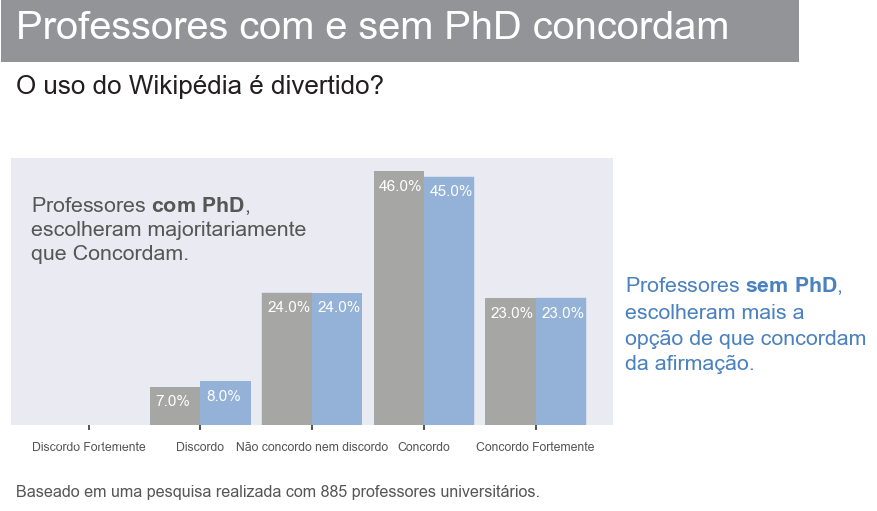

In [31]:
Y = list(round((phd_2[0]/len(data[data['PhD'] == 0]))*100, 0))
Z = list(round((phd_2[1]/len(data[data['PhD'] == 1]))*100, 0))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'Professores com e sem PhD concordam' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso do Wikipédia é divertido?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -13,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         'Professores $\\bf{com\ PhD}$,\n'  # use mathtext \\bf for bold text
         'escolheram majoritariamente\n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         'Professores $\\bf{sem\ PhD}$,\n'
         'escolheram mais a\n'
         'opção de que concordam\n'  # use mathtext \\mathit for italic text
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0)

Praticamente 45% dos professores com e sem PhD concordam que o uso do Wikipédia é divertido. As demais opções ficaram bem balanceadas em relação aos professores com e sem PhD.

In [32]:
wiki_2 = data.groupby(['USERWIKI', 'ENJ2'])['ENJ2'].count()

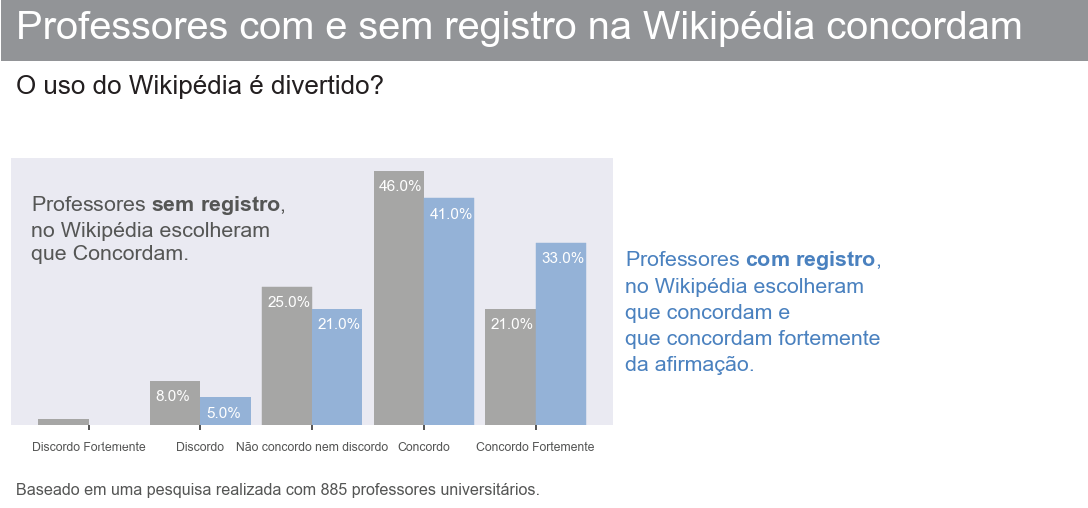

In [33]:
Z = [0.0]
Y = list(round((wiki_2[0]/len(data[data['USERWIKI'] == 0]))*100, 0))
Z.extend(list(round((wiki_2[1]/len(data[data['USERWIKI'] == 1]))*100, 0)))

# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# tune the subplot layout by setting sides of the figure
plt.subplots_adjust(left=0, right=0.735, top=0.665, bottom=0.17)

# There is no automatic support of subcategories bar plot in matplotlib.
def subcategorybar(X,  # categories names
                   vals,  # subcategories values
                   base_colors,  # base colors for each subcategory
                   special_colors,  # highlight colors for subcategories
                   special_bars,  # highlighted bars indicies 
                   width=0.9):  # total subcategories bars width
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        # draw i-th subcategory bars
        bars = plt.bar(_X - width / 2. + i / float(n) * width,
                       vals[i],
                       width=width / float(n),
                       align="edge",  # aligns bars by their left edges
                       color=base_colors[i])  # use base color for subcategory

        # add numerical data labels for each bar
        for bi, b in enumerate(bars):
            plt.text(b.get_x() + 0.05, b.get_height() - 3.5,
                     str(vals[i][bi]) + '%',
                     fontsize=10,
                     color='white')
        # highlight bars
        if special_bars[i] != None:
            for special_bar_i in special_bars[i]:
                bars[special_bar_i].set_color(special_colors[i])
    # set category tick locations and labels of the x-axis
    plt.xticks(_X, X)


# draw subcategorical vertical bar plot
subcategorybar(X,  # responses
               [Y, Z],  # pre- and post- responses distribution
               [GRAY8, BLUE3],  # colors for pre- and post- bars
               [GRAY8, BLUE3],  # highlight colors for pre- and post- bars
               [[2], [3, 4]])  # highlight 3rd pre- and 4th,5th post- bar

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# configure responses labels appearance
for item in plt.gca().get_xticklabels():
    item.set_fontsize(8)
    item.set_color(GRAY3)

# titile the plot
plt.text(-0.65, 70,
         'Professores com e sem registro na Wikipédia concordam' + ' ' * 5,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 10,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
plt.text(-0.65, 60, 'O uso do Wikipédia é divertido?', fontsize=17, 
         color=GRAY1)

# add footnote with the data source
plt.text(-0.65, -12.5,
         'Baseado em uma pesquisa realizada com 885 '
         'professores universitários. ',
         fontsize=10.5,
         color=GRAY3)

# add pre- note to plot
plt.text(-0.52, 30,
         'Professores $\\bf{sem\ registro}$,\n'  # use mathtext \\bf for bold text
         'no Wikipédia escolheram \n'
         'que Concordam.',  # use mathtext
         fontsize=14,
         linespacing=1.3,  # multiple of font size
         color=GRAY3)

# add post- note to plot
plt.text(4.8, 10,
         'Professores $\\bf{com\ registro}$,\n'
         'no Wikipédia escolheram \n'
         'que concordam e \n'  # use mathtext \\mathit for italic text
         'que concordam fortemente \n'
         'da afirmação.',
         fontsize=14,
         linespacing=1.45,  # multiple of font size
         color=BLUE2);

plt.tick_params(bottom='off', labelleft=False, left=False, grid_alpha=0)

Por fim, temos que 33% dos professores registrados no Wikipédia acreditam que o wikipédia é divertido enquanto os não cadastrados apenas 21% consideram fortemente divertido. Porém, ambos (46% e 41% dos professores com e sem PhD respectivamente) concordam com a afirmação que o wikipédia é divertido. 

## Conclusão

Após realizar esta análise incial é possível verificar que ainda existem diversas análises que poderiam ser realizadas nestes dados. Para começar é possível realizar uma análise dos componentes principais, utilizando clusterização e verificando grupos nos dados. Em seguida, seria possível realizar um processo de aprendizagem de máquina supervisionada para prêver se novos professores recomendariam ou não o wikipédia para os seus alunos.

Concluindo, é possível verificar como os professores se sentem em relação ao wikipédia em diferentes pontos de vista através destes dados. Porém, vale ressaltar que foram entrevistados professores de apenas duas faculdades, o que deixa os dados enviesados para este pequeno nicho. O ideal seria possuir uma amostra mais ampla, com mais universidades participando, o que daria uma visão mais geral sobre o assunto.

## Referências

* Os dados utilizado foram retirados do site: [UCI - Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/wiki4HE#)
* Os gráficos foram baseados nos gráficos do livro Storytelling with Data - Knaflic e códigos obtidos [deste github](https://github.com/empathy87/storytelling-with-data).